In [1]:
from numpy.random import seed
seed(35)

import numpy as np 
import pandas as pd 

import tensorflow
tensorflow.random.set_seed(35)
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import shutil

%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
os.listdir("../input/skin-cancer-mnist-ham10000")

['hmnist_28_28_L.csv',
 'ham10000_images_part_2',
 'hmnist_8_8_L.csv',
 'ham10000_images_part_1',
 'HAM10000_metadata.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'hmnist_8_8_RGB.csv',
 'HAM10000_images_part_2']

# Créer un fichier de structure pour les données 

In [3]:
%ls

__notebook_source__.ipynb


In [4]:
dir_name = "base"
os.mkdir(dir_name)

train = os.path.join(dir_name, "train_dir")
os.mkdir(train)

val = os.path.join(dir_name, 'val_dir')
os.mkdir(val)

In [5]:
# creation dossier dans train
nv = os.path.join(train, 'nv')
os.mkdir(nv)
mel = os.path.join(train, 'mel')
os.mkdir(mel)
bkl = os.path.join(train, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train, 'vasc')
os.mkdir(vasc)
df = os.path.join(train, 'df')
os.mkdir(df)

# creation dossier dans val
nv = os.path.join(val, 'nv')
os.mkdir(nv)
mel = os.path.join(val, 'mel')
os.mkdir(mel)
bkl = os.path.join(val, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val, 'vasc')
os.mkdir(vasc)
df = os.path.join(val, 'df')
os.mkdir(df)

# Analyse descriptive du data set 

In [6]:
data = pd.read_csv("../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


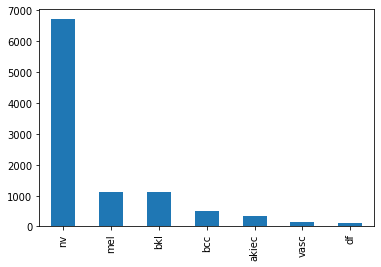

In [7]:
data["dx"].value_counts().plot.bar()

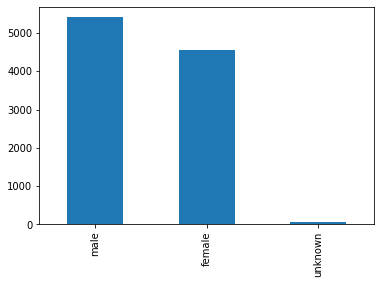

In [8]:
data["sex"].value_counts().plot.bar()

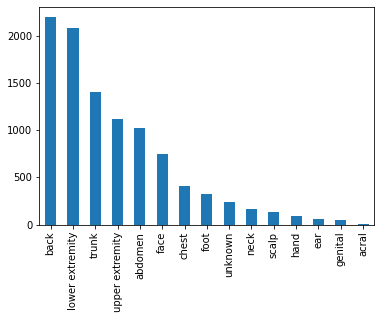

In [9]:
data["localization"].value_counts().plot.bar()

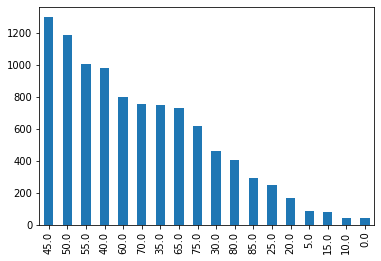

In [10]:
data["age"].value_counts().plot.bar()

In [11]:
print(len(data["lesion_id"]) == len(set(data["lesion_id"])))
print(len(data["image_id"]) == len(set(data["image_id"]))) 

False
True


On observe que le dataset comporte des doublons d'images

In [12]:
df = data.groupby("lesion_id").count()
df = df[df["image_id"] == 1]
df = df.reset_index()
print(len(df), len(data))

# Nous avons ici seulement les lesions comportant une images
df.head(5)

5514 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [13]:
unique = list(df.lesion_id)
def check_duplicates(a):
    if a in unique:
        return "unique"
    else :
        return "not_unique"

In [14]:
data["unique"] = data["lesion_id"].apply(check_duplicates)

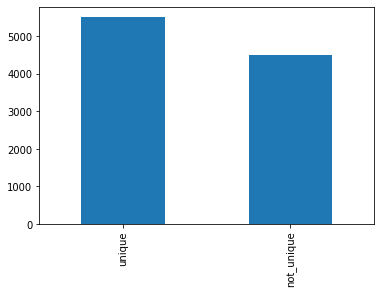

In [15]:
data["unique"].value_counts().plot.bar()

In [16]:
# Maintenant nous allons nous concentrer sur les lesions non dupliquées :
df = data[data["unique"] == "unique"]

df.shape

(5514, 8)

In [17]:
# Maintenant créons un set de validation sur df car nous savons que df ne contiens que les lesions unique 

y = df["dx"]

_, df_val = train_test_split(df, test_size=0.15, random_state=35, stratify=y)

In [18]:
df_val['dx'].value_counts()

nv       663
bkl       66
mel       34
bcc       26
akiec     23
vasc      10
df         6
Name: dx, dtype: int64

In [19]:
df_val.head(2)

,lesion_id,image_id,dx,dx_type,age,sex,localization,unique
6154,HAM_0005906,ISIC_0025609,nv,follow_up,40.0,male,trunk,unique
2810,HAM_0006386,ISIC_0029035,bcc,histo,70.0,male,face,unique


In [20]:
# Creation du train set 
def identify_train_val(x):
    id_val = list(df_val["image_id"])
    if str(x) in id_val:
        return 'val'
    else :
        return 'train'

In [21]:
data["train_ou_val"] = data["image_id"].apply(identify_train_val)

In [22]:
data_train = data[data["train_ou_val"] == 'train']

In [23]:
data.set_index('image_id', inplace = True)

In [24]:
#list des images disponibles 
part_1 = os.listdir("../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/")
part_2 = os.listdir("../input/skin-cancer-mnist-ham10000/ham10000_images_part_2/")

In [25]:
#list des images que nous allons utiliser pour le train et val set
im_train = data_train["image_id"]
im_val = df_val["image_id"]

In [26]:
#Transfert des images dans le train directory 
for image in im_train:
    name = image + ".jpg"
    label = data.loc[image, "dx"]
    
    if name in part_1:
        # Source de l'image
        src = os.path.join("../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/", name)
        #destination de l'image
        dst = os.path.join(train, label, name)
        #copier l'image
        shutil.copyfile(src, dst)
    if name in part_2:
        # Source de l'image
        src = os.path.join("../input/skin-cancer-mnist-ham10000/ham10000_images_part_2/", name)
        #destination de l'image
        dst = os.path.join(train, label, name)
        #copier l'image
        shutil.copyfile(src, dst)

In [27]:
#Transfert des images dans le val directory 
for image in im_val:
    name = image + ".jpg"
    label = data.loc[image, "dx"]
    
    if name in part_1:
        # Source de l'image
        src = os.path.join("../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/", name)
        #destination de l'image
        dst = os.path.join(val, label, name)
        #copier l'image
        shutil.copyfile(src, dst)
    if name in part_2:
        # Source de l'image
        src = os.path.join("../input/skin-cancer-mnist-ham10000/ham10000_images_part_2/", name)
        #destination de l'image
        dst = os.path.join(val, label, name)
        #copier l'image
        shutil.copyfile(src, dst)

In [28]:
%ls base/train_dir

akiec/  bcc/  bkl/  df/  mel/  nv/  vasc/


In [29]:
#vérification du bon déroulement du transfert 
lab = os.listdir("base/train_dir")
for x in lab:
    print("train_"+x, ":", len(os.listdir("base/train_dir/"+x)))
print(" ")
for x in lab:
    print("val_"+x, ":", len(os.listdir("base/val_dir/"+x)))

train_nv : 6042
train_bkl : 1033
train_bcc : 488
train_akiec : 304
train_mel : 1079
train_vasc : 132
train_df : 109
 
val_nv : 663
val_bkl : 66
val_bcc : 26
val_akiec : 23
val_mel : 34
val_vasc : 10
val_df : 6


In [30]:
# Ici je créer un fichier temporaire pour y mettre les images.
# Le but est d'avoir le même nombre d'image pour chaque class.  

for im_lab in lab:
    
    aug = 'aug_dir'
    os.mkdir(aug)
    
    im_dir = os.path.join(aug, 'im_dir')
    os.mkdir(im_dir)
    
    img_list = os.listdir("base/train_dir/" + im_lab)
    
    for name in img_list:
        src = os.path.join("base/train_dir/"+ im_lab, name)
        dst = os.path.join(im_dir, name)
        shutil.copyfile(src, dst)
        
    path = aug
    save_path = "base/train_dir/" + im_lab
    
    #Maintenant que les images sont dans le répertoire aug nous allons augmenter les données et les rajouter au répertoire train
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)
    
    #Nous souhaitons disposer de 6000 données par classe
    num_aug_images_wanted = 6000
    
    num_files = len(os.listdir(im_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # Suppression du fichier temporaire
    shutil.rmtree(aug)

Found 6042 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 304 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 132 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [31]:
#vérification du bon déroulement de l'augmentation  
for x in lab:
    print("train_"+x, ":", len(os.listdir("base/train_dir/"+x)))

train_nv : 6042
train_bkl : 5965
train_bcc : 5906
train_akiec : 5268
train_mel : 5945
train_vasc : 5330
train_df : 4410


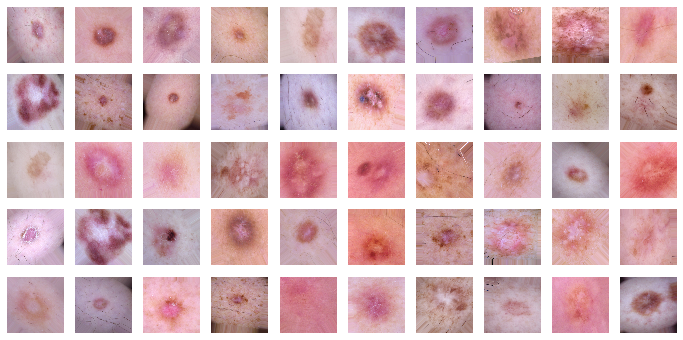

In [32]:
# Affichage des images avec labels 
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

# Création du modèle 

In [33]:
train_path = "base/train_dir/"
val_path = "base/val_dir/"

nb_train_samples = len(data_train)
nb_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

np_train_steps = np.ceil(nb_train_samples/train_batch_size)
np_val_steps = np.ceil(nb_val_samples/val_batch_size)

In [34]:
# Au vu de la performance des modèles pré-entrainer, j'ai choisi de faire du transfert learning 
# Plus particulièrement j'ai choisi d'utiliser le modèle MobileNet pour relativement faible coup de calcul à l'entrainement 
# Source : https://www.quantmetry.com/mobilenet-optimisation-de-la-convolution-pour-les-reseaux-de-neurones-embarques/

datagen = ImageDataGenerator(
    preprocessing_function= tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(val_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(val_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38866 images belonging to 7 classes.
Found 828 images belonging to 7 classes.
Found 828 images belonging to 7 classes.


In [35]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [36]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [37]:
print(type(mobile.layers))
print(len(mobile.layers))

<class 'list'>
93


In [38]:
# Nous allons retirer les 5 dernières couches du réseaux 
x = mobile.layers[-6].output

# Création d'une nouvelle couche Dense 
# 7 corresponds auxnombre de classe en sortie 
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [40]:
# Nous allons freezer  tous les poids sauf pour les 23 dernières couches 
for layer in model.layers[:-23]:
    layer.trainable = False

# Entrainement du model 

In [42]:
#  Top2 et Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [43]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [44]:
# Label associé à chaque classe :
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [45]:
# Ajout de poids pour faire en sorte que le model soit plus senssible au mélanome:

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Tous les poids sont a 1 sauf le melanome qui est à 3.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [49]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=np_train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=np_val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Train for 919.0 steps, validate for 83.0 steps
Epoch 1/30
917/919 [============================>.] - ETA: 0s - loss: 1.7562 - categorical_accuracy: 0.5180 - top_2_accuracy: 0.7160 - top_3_accuracy: 0.8410 ETA: 1s - loss: 1.7641 - categorical_accuracy: 0.5171 - top_2_accuracy: 0
Epoch 00001: val_top_3_accuracy improved from -inf to 0.90942, saving model to model.h5
919/919 [==============================] - 61s 66ms/step - loss: 1.7555 - categorical_accuracy: 0.5181 - top_2_accuracy: 0.7163 - top_3_accuracy: 0.8411 - val_loss: 1.7576 - val_categorical_accuracy: 0.3647 - val_top_2_accuracy: 0.7464 - val_top_3_accuracy: 0.9094
Epoch 2/30
918/919 [============================>.] - ETA: 0s - loss: 1.2628 - categorical_accuracy: 0.6139 - top_2_accuracy: 0.8162 - top_3_accuracy: 0.9157
Epoch 00002: val_top_3_accuracy improved from 0.90942 to 0.94444, saving model to model.h5
919/919 [==============================] - 53s 58ms/step - loss: 1.2635 - categorical_accuracy: 0.6139 - top_2_accuracy

Epoch 17/30
917/919 [============================>.] - ETA: 0s - loss: 0.2087 - categorical_accuracy: 0.9435 - top_2_accuracy: 0.9887 - top_3_accuracy: 0.9989
Epoch 00017: val_top_3_accuracy did not improve from 0.96135
919/919 [==============================] - 53s 58ms/step - loss: 0.2088 - categorical_accuracy: 0.9434 - top_2_accuracy: 0.9887 - top_3_accuracy: 0.9989 - val_loss: 1.4635 - val_categorical_accuracy: 0.7428 - val_top_2_accuracy: 0.8816 - val_top_3_accuracy: 0.9324
Epoch 18/30
918/919 [============================>.] - ETA: 0s - loss: 0.1871 - categorical_accuracy: 0.9504 - top_2_accuracy: 0.9885 - top_3_accuracy: 0.9983
Epoch 00018: val_top_3_accuracy did not improve from 0.96135

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
919/919 [==============================] - 53s 58ms/step - loss: 0.1870 - categorical_accuracy: 0.9505 - top_2_accuracy: 0.9885 - top_3_accuracy: 0.9983 - val_loss: 1.5606 - val_categorical_accuracy: 0.7367 - val_t

In [50]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [51]:
# Evaluation du model pour la dernière epoch
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate_generator(test_batches,steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 1.3628314046177834
val_cat_acc: 0.7451691
val_top_2_acc: 0.884058
val_top_3_acc: 0.9432367


In [52]:
# Evaluation du model pour la meilleure epoch

model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate_generator(test_batches, steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.561903191186416
val_cat_acc: 0.82246375
val_top_2_acc: 0.9166667
val_top_3_acc: 0.96135265


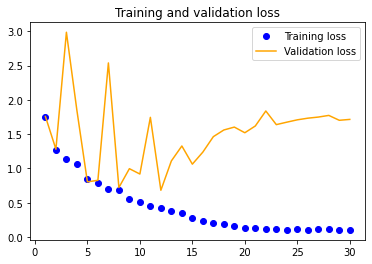

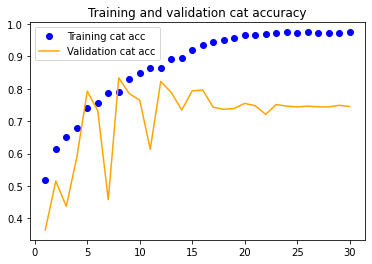

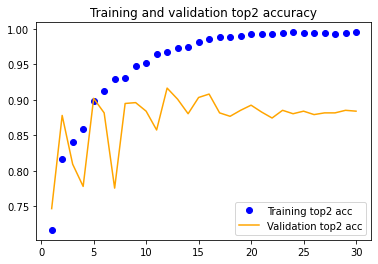

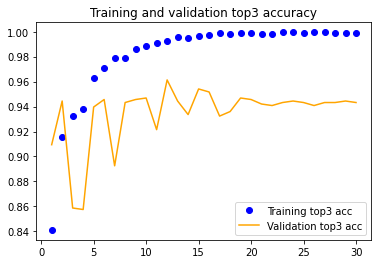

In [53]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss', color = 'blue')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'orange')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc', color = 'blue')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc', color = 'orange')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc', color = 'blue')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc', color = 'orange')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc', color = 'blue')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc', color = 'orange')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [54]:
# Matrice de confusion
test_labels = test_batches.classes
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

828/828 [==============================] - 13s 15ms/step


In [57]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  4   5   4   1   5   4   0]
 [  0  21   0   0   3   2   0]
 [  4   8  14   1  20  18   1]
 [  0   0   0   5   0   1   0]
 [  3   2   1   1  18   9   0]
 [  0  10   2   3  30 615   3]
 [  0   0   0   0   0   6   4]]


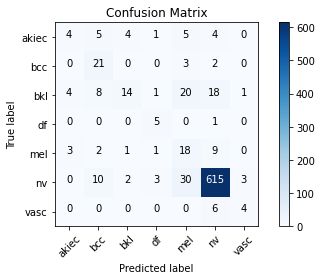

In [58]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [59]:
# Index de la classe avec la plus grande probabilité
y_pred = np.argmax(predictions, axis=1)

# label des images test
y_true = test_batches.classes

In [60]:
from sklearn.metrics import classification_report

# Génération d'un classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.36      0.17      0.24        23
         bcc       0.46      0.81      0.58        26
         bkl       0.67      0.21      0.32        66
          df       0.45      0.83      0.59         6
         mel       0.24      0.53      0.33        34
          nv       0.94      0.93      0.93       663
        vasc       0.50      0.40      0.44        10

    accuracy                           0.82       828
   macro avg       0.52      0.55      0.49       828
weighted avg       0.85      0.82      0.82       828



In [76]:
test_batches

In [77]:
model.predict(test_batches)

AttributeError: 'DirectoryIterator' object has no attribute 'shape'

### Convertion du model en tensorflowjs

In [66]:
!pip install tensorflowjs

     |████████████████████████████████| 57 kB 1.6 MB/s eta 0:00:011
     |████████████████████████████████| 104.6 MB 72 kB/s s eta 0:00:01
     |████████████████████████████████| 248 kB 47.8 MB/s eta 0:00:01
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-py3-none-any.whl size=32849 sha256=cc29f6322aa6238a03784b05e96a51c970d9e16e339f4bb7e9d021a156eb992d
  Stored in directory: /root/.cache/pip/wheels/79/8e/a2/5043c19fe89c93e2ae1adb66d066ff743057e70dd0ccbed62c
Successfully built PyInquirer
ERROR: jupyter-console 6.1.0 has requirement prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.14 which is incompatible.
ERROR: ipython 7.13.0 has requirement prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.14 which is incompatible.
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.4
    Uninstalling prompt-toolkit-3.0.4:
      Successfully uninstalled prompt-toolkit-3.0.4


In [67]:
# create a directory to store the model files
os.mkdir('tfjs_dir')

# convert to Tensorflow.js
import tensorflowjs as tfjs

# Error
# AttributeError: module 'tensorflow.python.data.ops.dataset_ops' 
    # has no attribute 'UnaryDataset'


In [69]:
tfjs.converters.save_keras_model(model, 'tfjs_dir')

/opt/conda/lib/python3.6/site-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [72]:
!ls tfjs_dir

group1-shard1of4.bin  group1-shard3of4.bin  model.json
group1-shard2of4.bin  group1-shard4of4.bin


In [73]:
os.listdir('tfjs_dir')

['group1-shard2of4.bin',
 'model.json',
 'group1-shard3of4.bin',
 'group1-shard1of4.bin',
 'group1-shard4of4.bin']

In [75]:
shutil.rmtree('tfjs_dir')